In [1]:
%load_ext tensorboard
import tensorflow as tf
tf.__version__


'1.14.0'

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from matplotlib.image import imread
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split


from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [3]:
# Set some parameters
im_width = 256
im_height = 256
border = 5
path_train = os.path.join( os.getcwd(), 'input',  'train')
path_test = os.path.join( os.getcwd(), 'input',  'test')

In [4]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "\images"))[2]
    mask_ids = next(os.walk(path + '\masks'))[2]
    X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(mask_ids), im_height, im_width, 3), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        #img = load_img(path + '/images/' + id_, grayscale=False)
        img = imread(path + '/images/' + id_)
        #(b, g, r)=cv2.split(img)
        #img=cv2.merge([r,g,b])
        x_img = img_to_array(img)
        x_img = resize(x_img, (256, 256, 3), mode='constant', preserve_range=True)
        # Save images
        X[n, ..., 0] = x_img[:,:,0].squeeze() / 255
        X[n, ..., 1] = x_img[:,:,1].squeeze() / 255
        X[n, ..., 2] = x_img[:,:,2].squeeze() / 255
        #X.append(x_img/255)
    for n, id_ in tqdm_notebook(enumerate(mask_ids), total=len(mask_ids)):
    # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_ , grayscale=False))
            mask = resize(mask, (256, 256, 3), mode='constant', preserve_range=True)
        if train:
            #y[n] = mask / 255 
            y[n, ..., 0] = mask[:,:,0].squeeze() / 255
            y[n, ..., 1] = mask[:,:,1].squeeze() / 255
            y[n, ..., 2] = mask[:,:,2].squeeze() / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(path_train, train=True)

Getting and resizing images ... 



Done!


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
def plot_img(ix):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(X_train[ix])
    ax[0].set_title('Image')

    ax[1].imshow(y_train[ix])
    ax[1].set_title('mask');

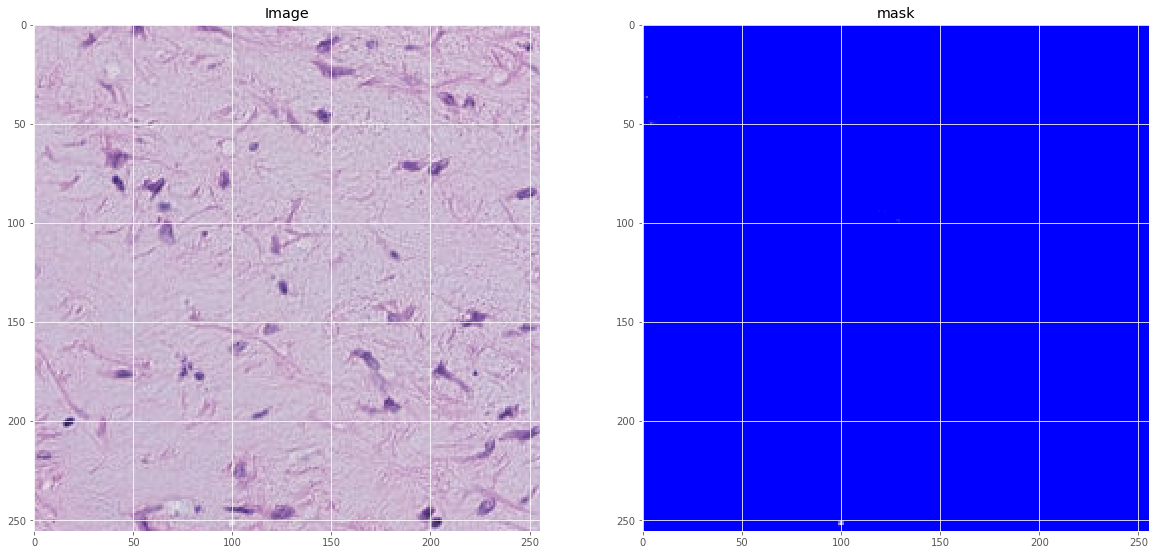

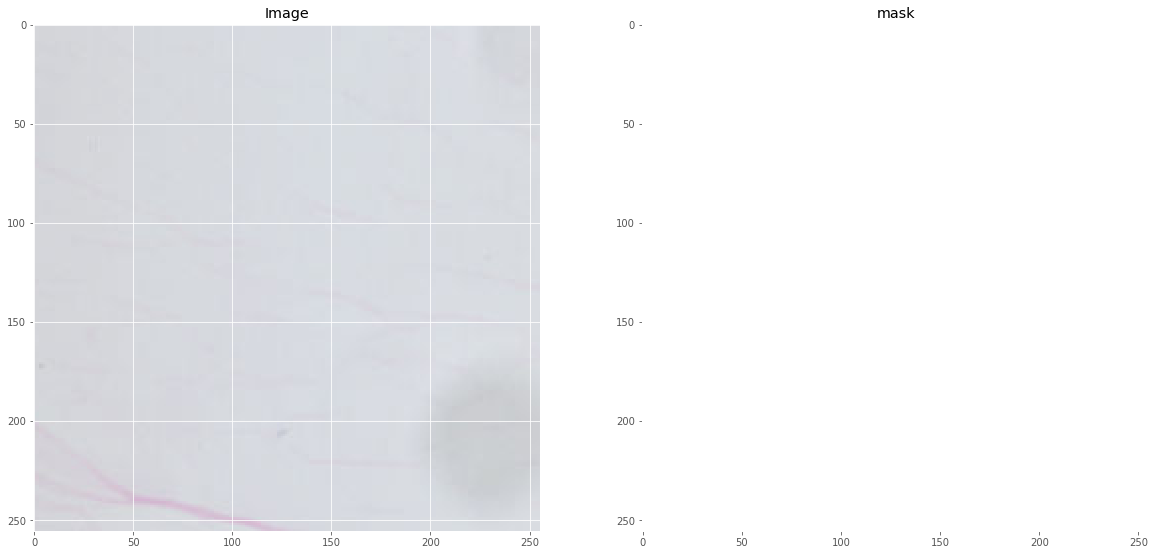

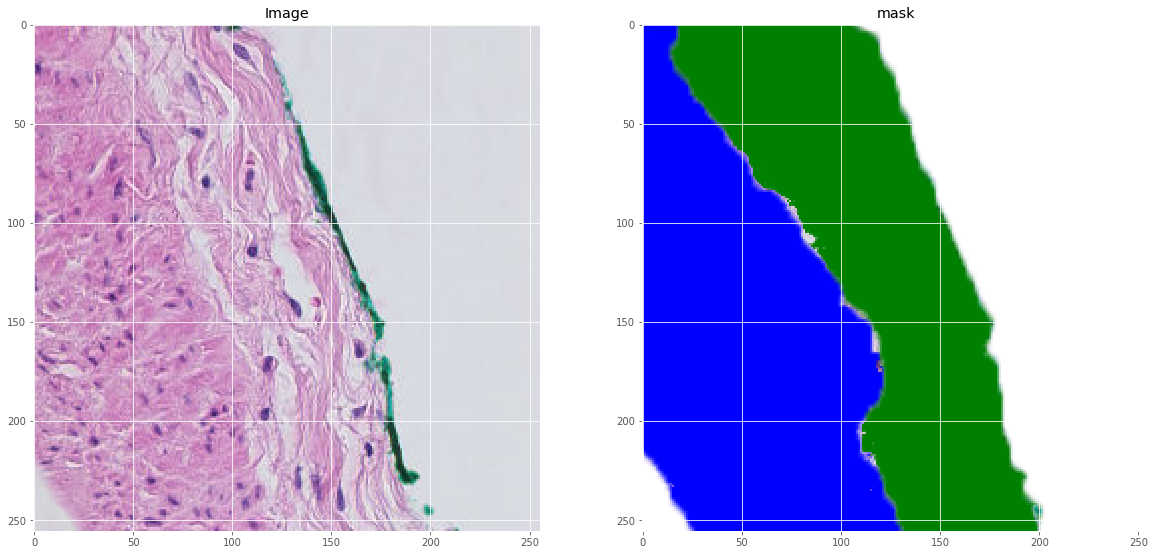

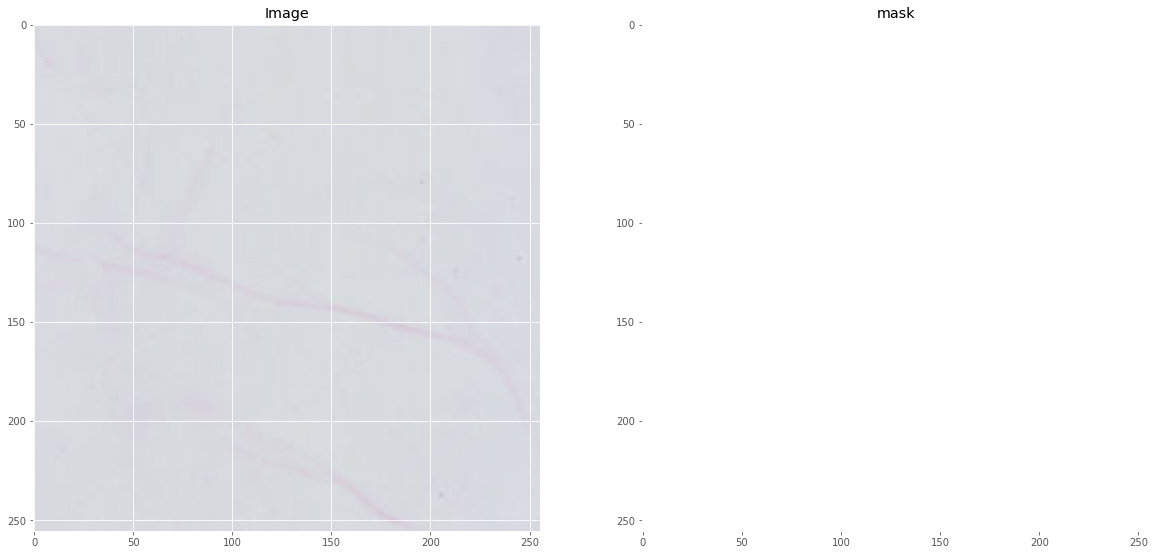

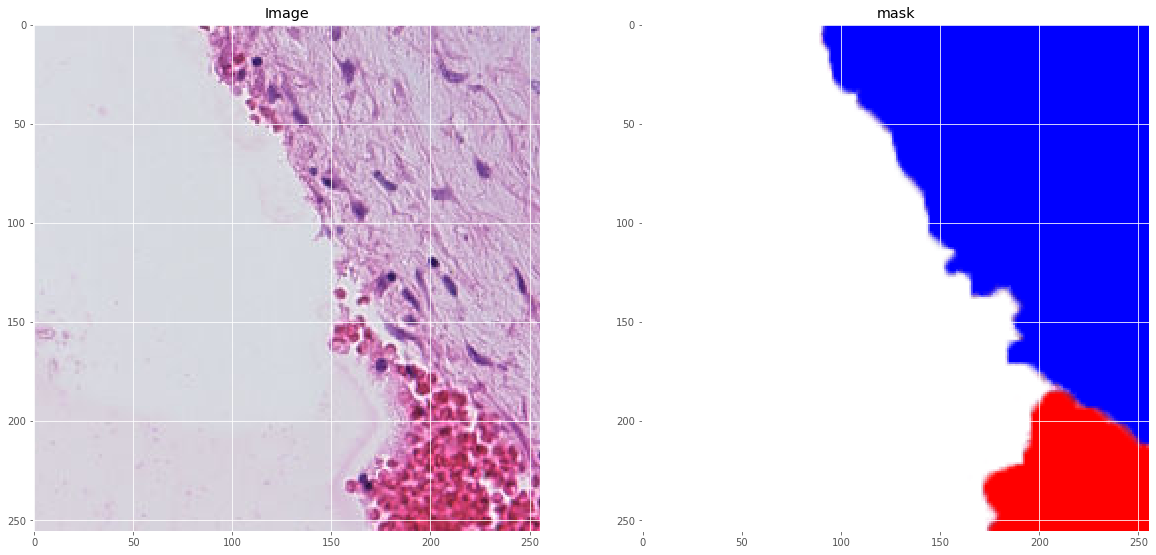

In [7]:
for i in range(0,5):
    ix = random.randint(0, len(X_train))
    plot_img(ix)


In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [9]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

W1009 11:59:58.570451  9584 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 11:59:58.604363  9584 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1009 11:59:58.607321  9584 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1009 11:59:58.674179  9584 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1009 11:59:58.676170  9584 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 256)  0           conv2d_transpose_1[0][0]         
                                                                 activation_8[0][0]               
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 32, 32, 256)  0           concatenate_1[0][0]              
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 128)  295040      dropout_5[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 32, 32, 128)  512         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

In [11]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-basic.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(logdir, histogram_freq=1)
]

In [12]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 481 samples, validate on 86 samples


W1009 12:00:18.624547  9584 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\callbacks.py:848: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W1009 12:00:19.343537  9584 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1009 12:00:19.357483  9584 deprecation_wrapper.py:119] From C:\Users\785pa\Anaconda3\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
481/481 [==============================] - ETA: 8:24 - loss: 0.8525 - acc: 0.413 - ETA: 6:22 - loss: 0.8270 - acc: 0.449 - ETA: 5:25 - loss: 0.8060 - acc: 0.472 - ETA: 4:50 - loss: 0.7807 - acc: 0.503 - ETA: 4:21 - loss: 0.7575 - acc: 0.529 - ETA: 3:57 - loss: 0.7343 - acc: 0.550 - ETA: 3:29 - loss: 0.7122 - acc: 0.566 - ETA: 3:04 - loss: 0.6937 - acc: 0.587 - ETA: 2:37 - loss: 0.6787 - acc: 0.603 - ETA: 2:11 - loss: 0.6672 - acc: 0.620 - ETA: 1:45 - loss: 0.6534 - acc: 0.637 - ETA: 1:20 - loss: 0.6458 - acc: 0.648 - ETA: 54s - loss: 0.6352 - acc: 0.659 - ETA: 27s - loss: 0.6242 - acc: 0.67 - ETA: 0s - loss: 0.6159 - acc: 0.6809 - 439s 913ms/step - loss: 0.6160 - acc: 0.6808 - val_loss: 0.3458 - val_acc: 0.8539

Epoch 00001: val_loss improved from inf to 0.34580, saving model to model-unet-basic.h5
Epoch 2/100
481/481 [==============================] - ETA: 3:15 - loss: 0.4653 - acc: 0.826 - ETA: 3:16 - loss: 0.4688 - acc: 0.824 - ETA: 3:05 - loss: 0.4853 - acc: 0.825 - ETA

481/481 [==============================] - ETA: 4:00 - loss: 0.3162 - acc: 0.920 - ETA: 3:38 - loss: 0.3201 - acc: 0.896 - ETA: 3:20 - loss: 0.3168 - acc: 0.899 - ETA: 3:01 - loss: 0.3168 - acc: 0.897 - ETA: 2:43 - loss: 0.3142 - acc: 0.898 - ETA: 2:27 - loss: 0.3142 - acc: 0.901 - ETA: 2:10 - loss: 0.3187 - acc: 0.892 - ETA: 1:53 - loss: 0.3197 - acc: 0.887 - ETA: 1:37 - loss: 0.3204 - acc: 0.886 - ETA: 1:21 - loss: 0.3197 - acc: 0.886 - ETA: 1:05 - loss: 0.3199 - acc: 0.888 - ETA: 48s - loss: 0.3192 - acc: 0.890 - ETA: 32s - loss: 0.3188 - acc: 0.89 - ETA: 16s - loss: 0.3178 - acc: 0.89 - ETA: 0s - loss: 0.3189 - acc: 0.8930 - 258s 536ms/step - loss: 0.3193 - acc: 0.8926 - val_loss: 0.2935 - val_acc: 0.9091

Epoch 00011: val_loss did not improve from 0.28840
Epoch 12/100
481/481 [==============================] - ETA: 3:40 - loss: 0.3205 - acc: 0.897 - ETA: 3:25 - loss: 0.3157 - acc: 0.890 - ETA: 3:09 - loss: 0.3160 - acc: 0.903 - ETA: 2:53 - loss: 0.3150 - acc: 0.900 - ETA: 2:39 - l

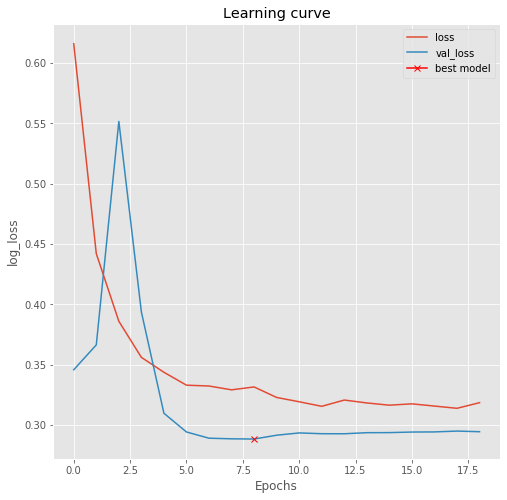

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [14]:
# Load best model
model.load_weights('model-unet-basic.h5')

In [15]:
model.evaluate(X_valid, y_valid, verbose=1)

86/86 [==============================] - ETA: 19 - ETA: 7 - 30s 348ms/step


[0.2884014796379001, 0.9063635108082794]

In [16]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

86/86 [==============================] - ETA: 18 - ETA: 7 - 29s 343ms/step


In [17]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
   
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
   
    ax[2].set_title('Mask Predicted')
    


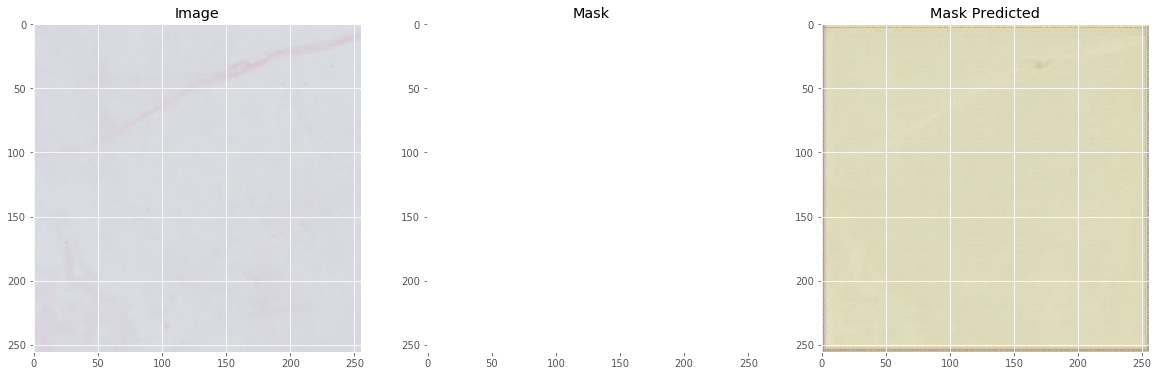

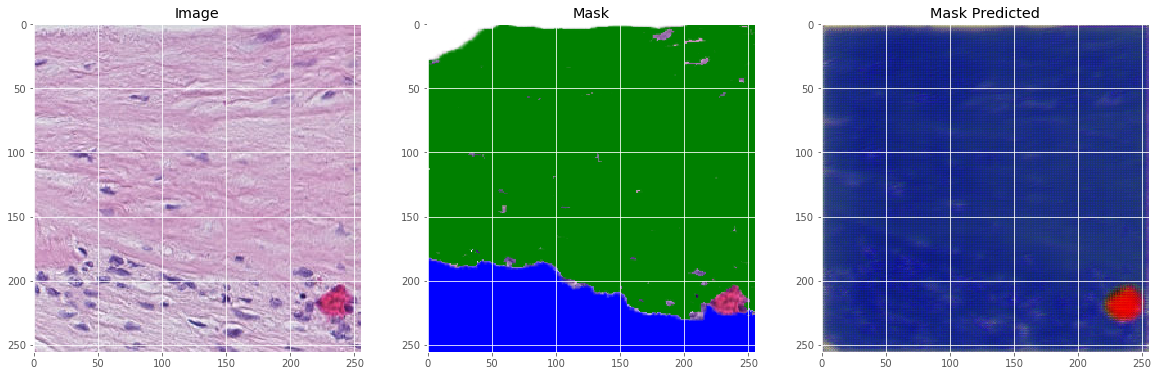

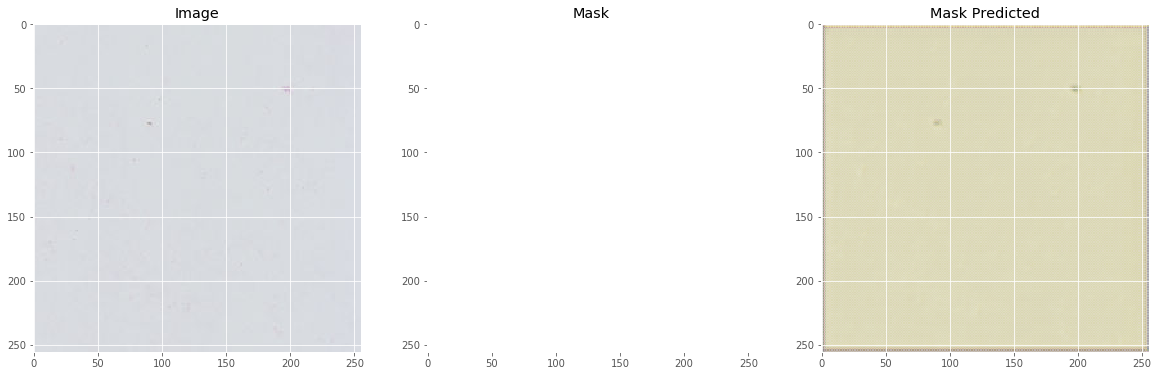

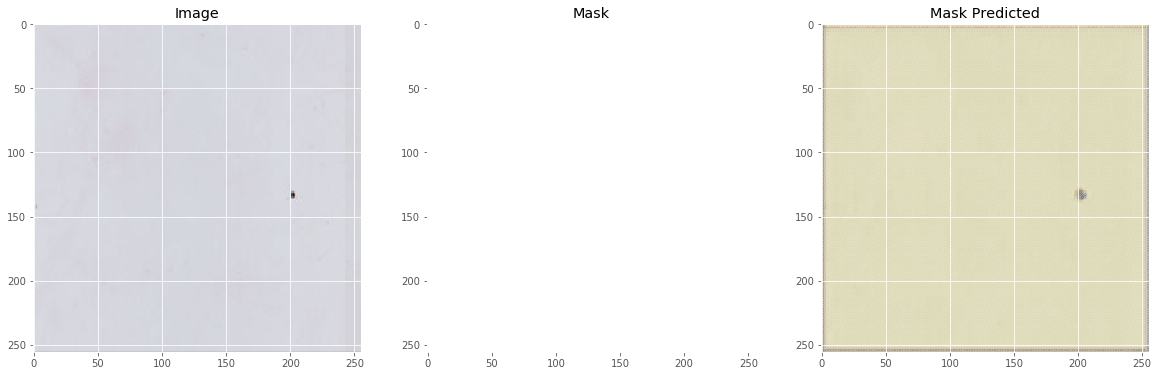

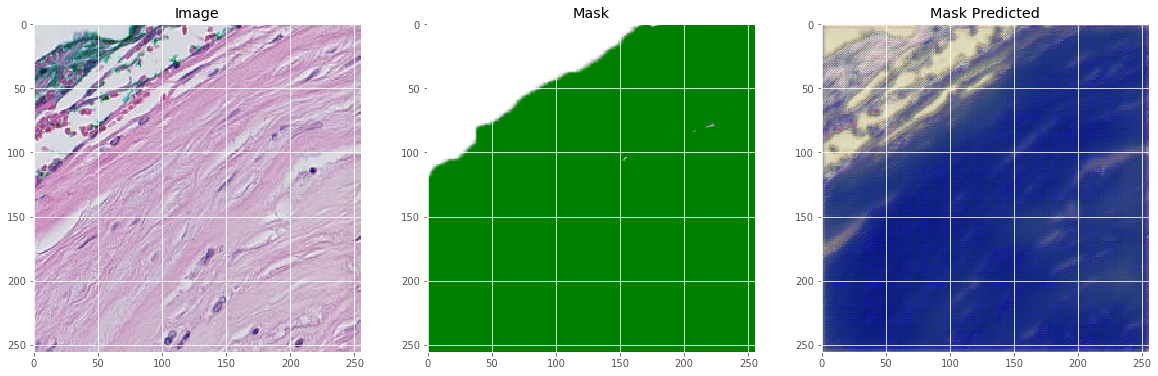

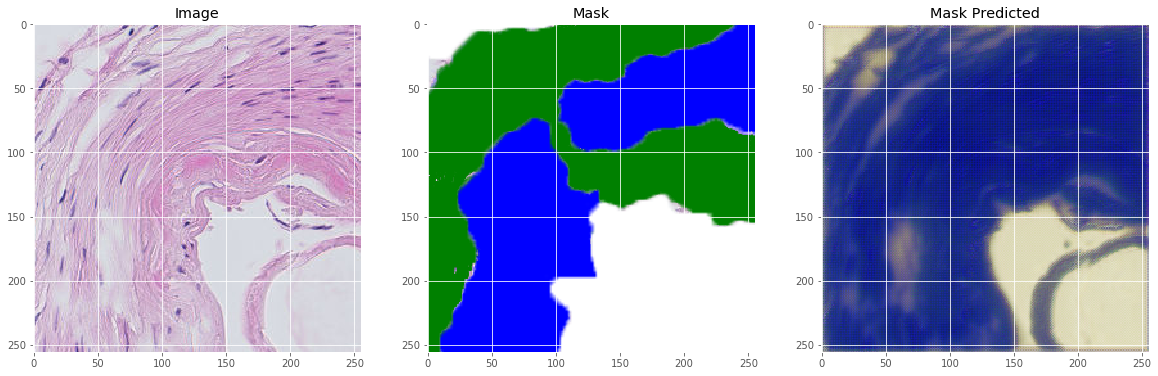

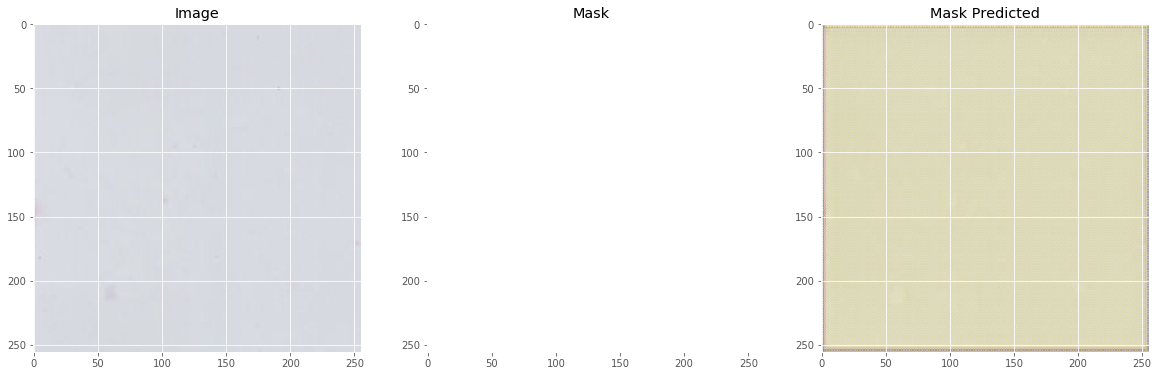

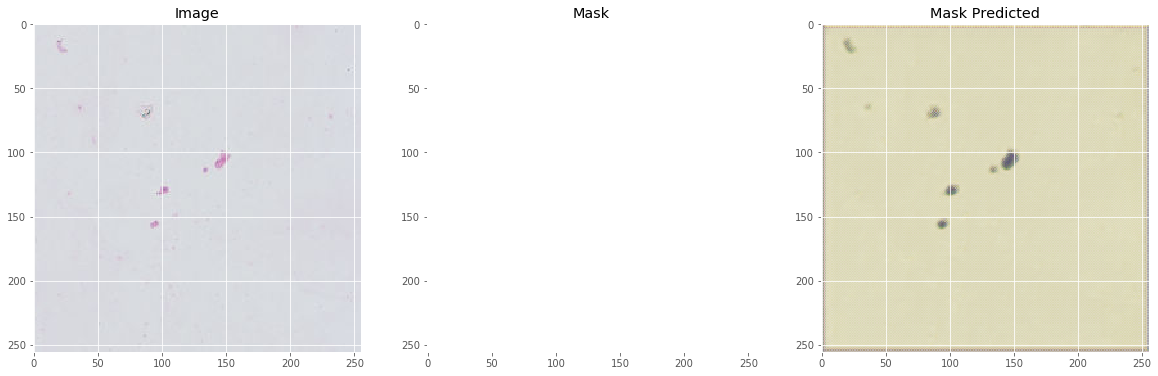

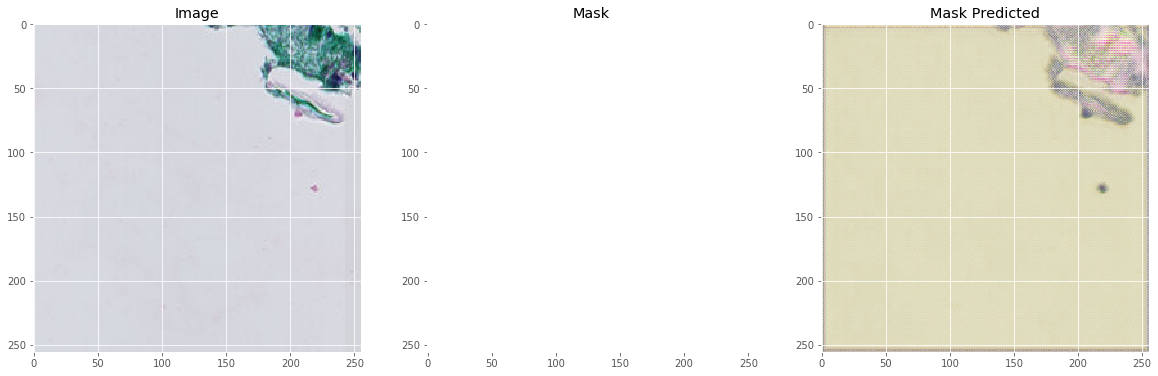

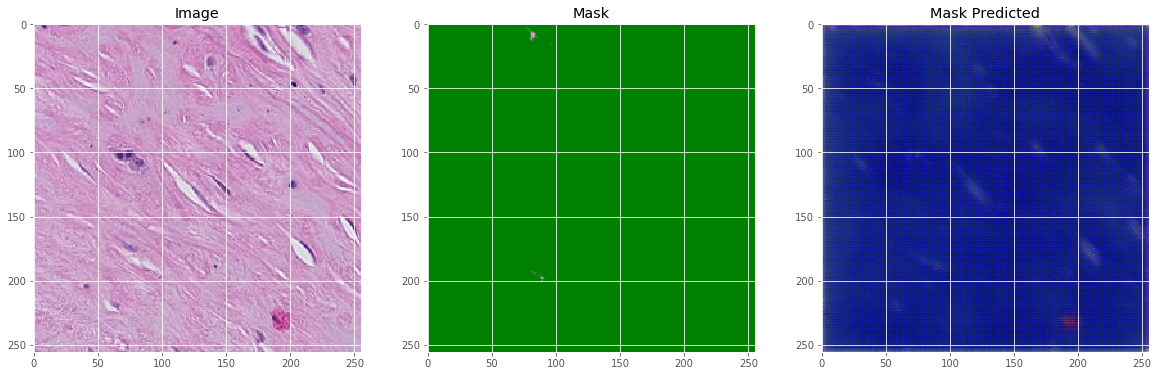

In [35]:
# Check if training data looks all right
for i in range(0,10):
    plot_sample(X_train, y_train, preds_train, preds_train_t)

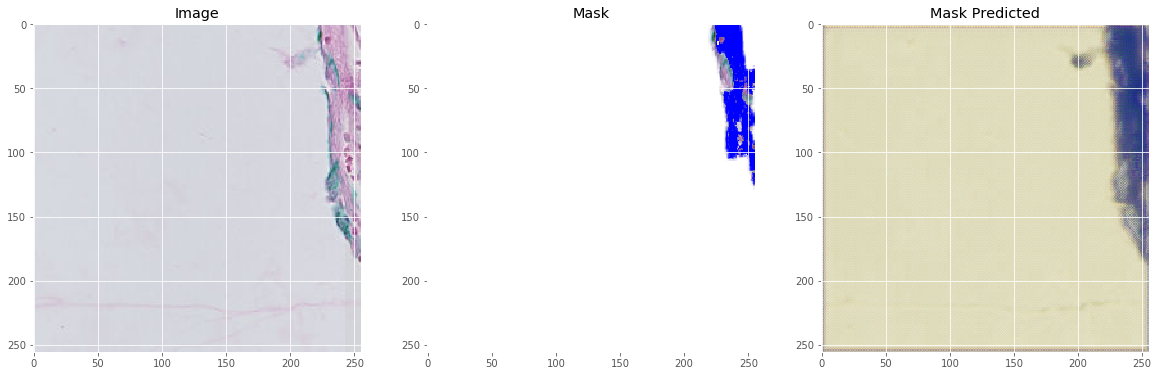

In [32]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [20]:
path_test = os.path.join( os.getcwd(), 'input',  'test')
X_test, y_test = get_data(path_test, train=True)

Getting and resizing images ... 



Done!


In [21]:
preds_test = model.predict(X_test, verbose=1)

22/22 [==============================] - 8s 364ms/step


In [22]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

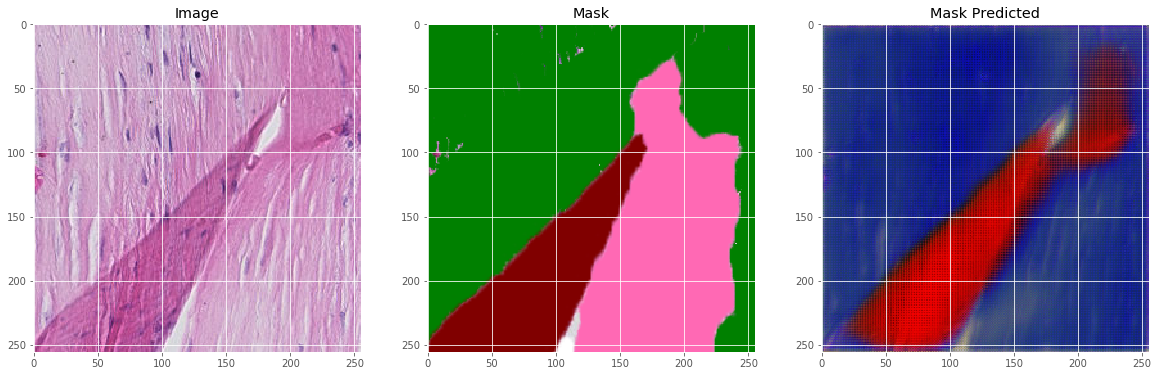

In [23]:
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=15)

In [24]:
path_big = os.path.join(os.getcwd(), 'input', 'big')
X_big, y_big = get_data(path_big, train=True)

Getting and resizing images ... 



Done!


In [25]:
preds_big = model.predict(X_test, verbose=1)

22/22 [==============================] - 8s 351ms/step


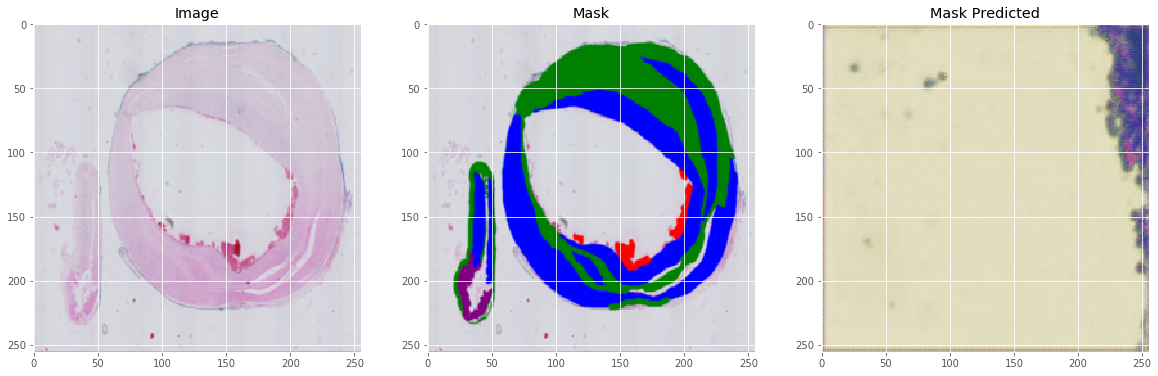

In [26]:
preds_big_t = (preds_big > 0.5).astype(np.uint8)
plot_sample(X_big, y_big, preds_big, preds_big_t, ix=0)

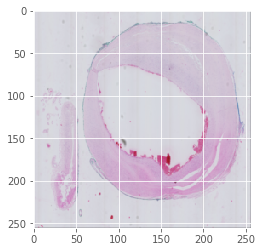

In [27]:
plt.imshow(X_big[0])

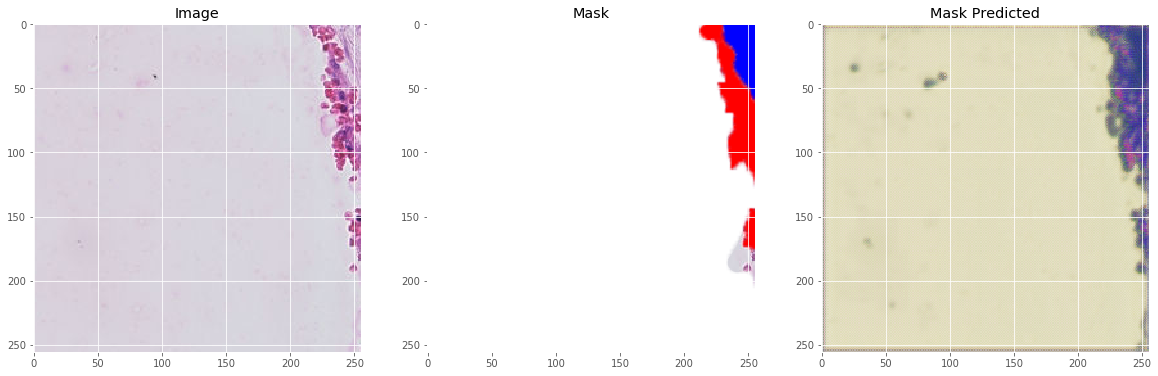

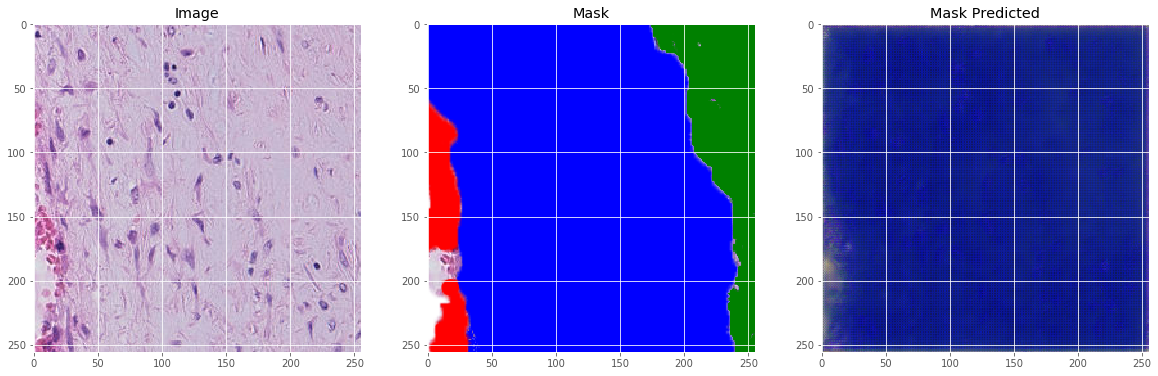

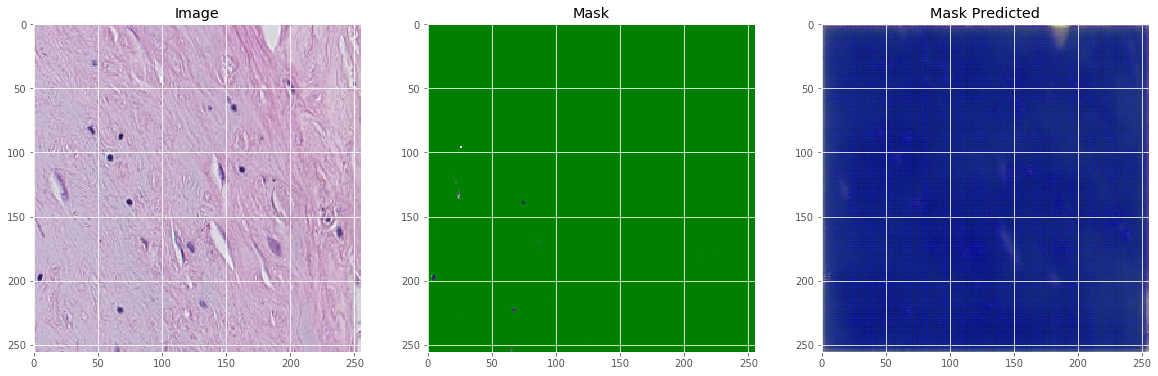

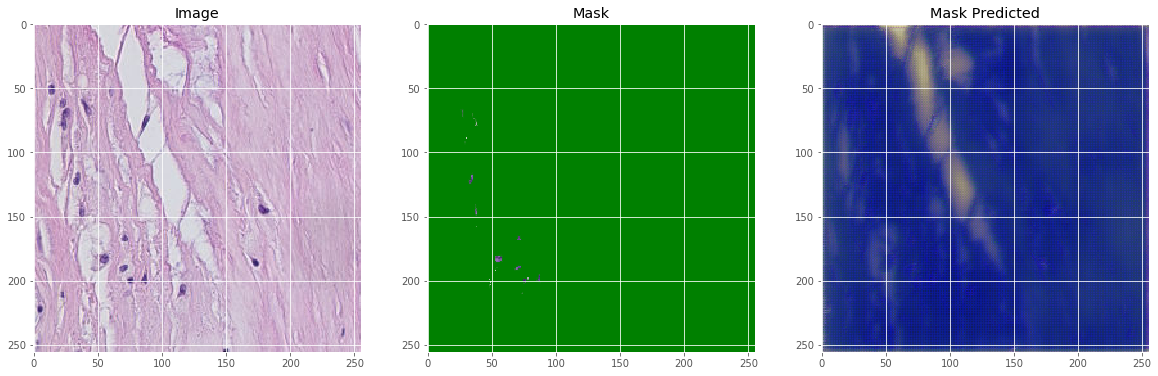

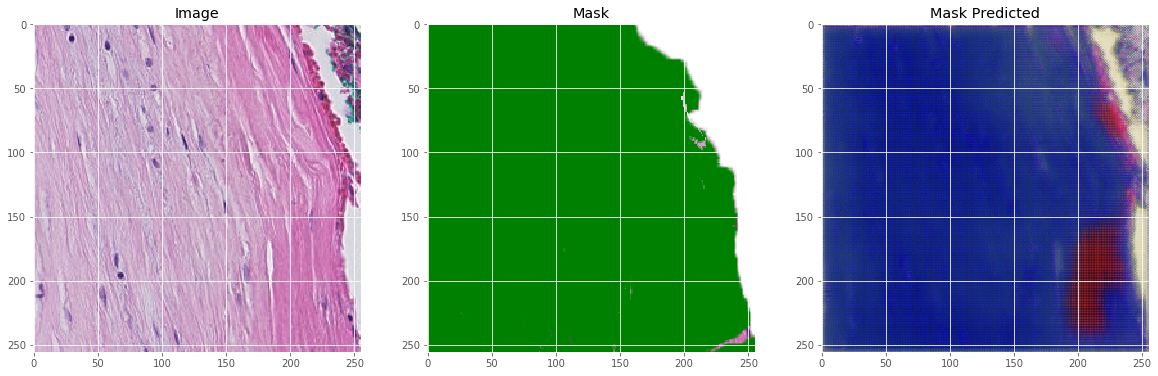

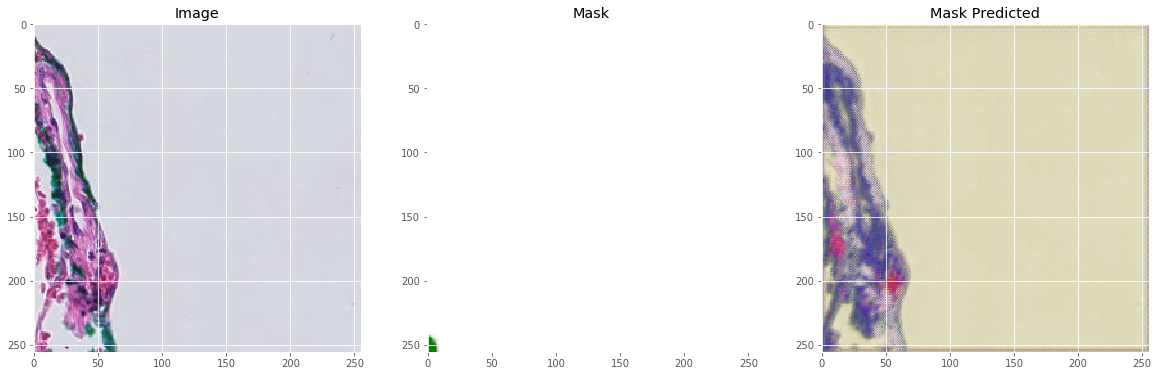

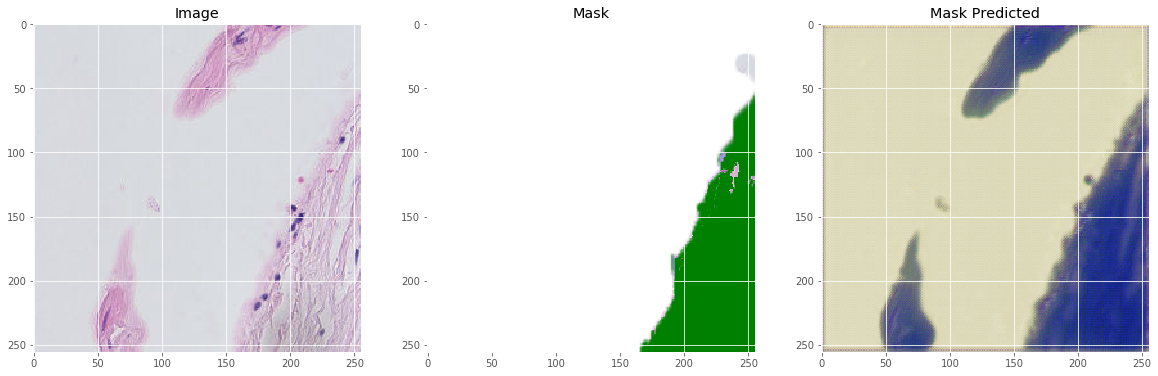

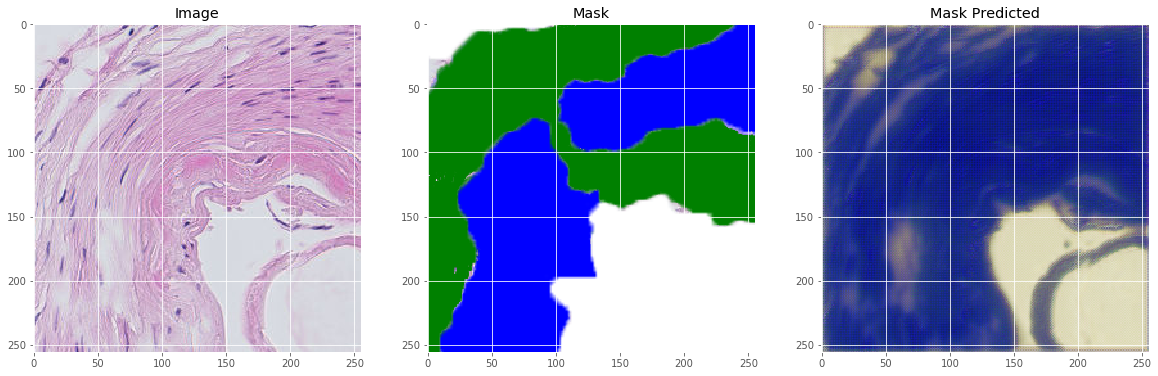

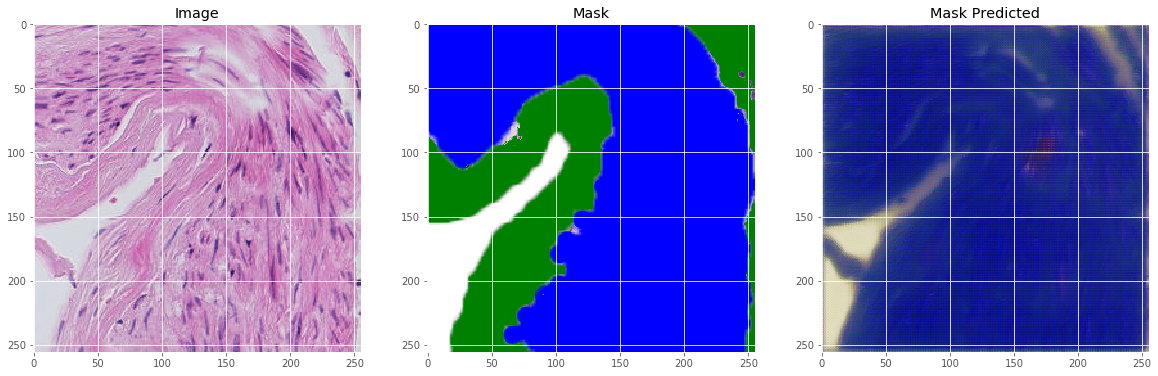

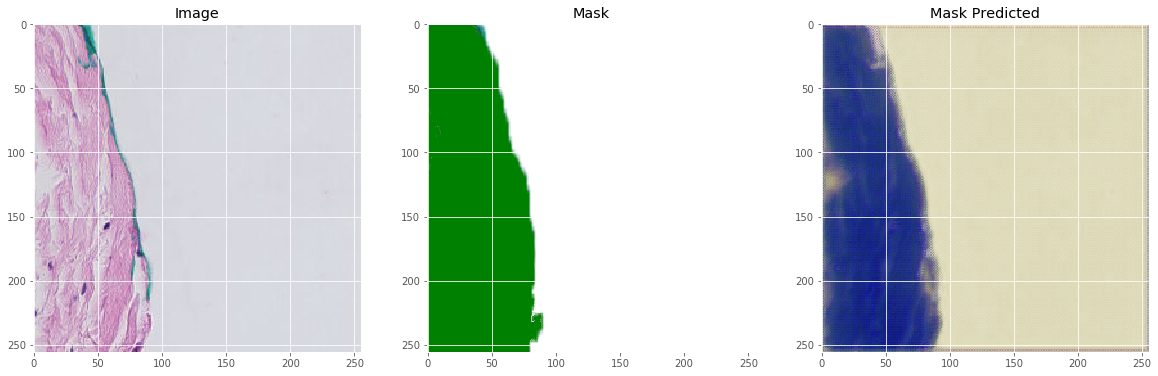

In [28]:
for i in range(10):
    plot_sample(X_test, y_test, preds_test, preds_test_t, ix=i)

In [29]:
%tensorboard --logdir log\s

Reusing TensorBoard on port 6006 (pid 32216), started 2:48:53 ago. (Use '!kill 32216' to kill it.)

W1009 14:19:31.062473  9584 manager.py:321] invalid info file: 'C:\\Users\\785pa\\AppData\\Local\\Temp\\.tensorboard-info\\pid-14756.info'
Traceback (most recent call last):
  File "C:\Users\785pa\Anaconda3\lib\site-packages\tensorboard\manager.py", line 316, in get_all
    info = _info_from_string(contents)
  File "C:\Users\785pa\Anaconda3\lib\site-packages\tensorboard\manager.py", line 155, in _info_from_string
    raise ValueError("incompatible version: %r" % (json_value,))
ValueError: incompatible version: {'cache_key': 'eyJhcmd1bWVudHMiOlsiLS1sb2dkaXIiLCJsb2dzIl0sImNvbmZpZ3VyZV9rd2FyZ3MiOnt9LCJ3b3JraW5nX2RpcmVjdG9yeSI6IkQ6XFx3YWxsX3NlZ21lbnRhdGlvblxcYmFzaWNNb2RlbC4wMDFcXHVuZmlsdGVyZWQifQ==', 'db': '', 'logdir': 'logs', 'path_prefix': '', 'pid': 14756, 'port': 6006, 'start_time': 1570482251, 'version': '2.1.0a20191007'}
W1009 14:19:31.067459  9584 manager.py:321] invalid info file: 'C:\\Users\\785pa\\AppData\\Local\\Temp\\.tensorboard-info\\pid-18368.info'
Traceback (most recent ca